# Пример использования библиотеки BigARTM для тематического моделирования

Импортируем BigARTM:

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import artm

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [4]:
batch_vectorizer = artm.BatchVectorizer(data_path="school.txt", data_format="vowpal_wabbit", target_folder="school_batches", 
                                       batch_size=100)

В следующий раз данные можно считывать уже из батчей:

In [5]:
batch_vectorizer = artm.BatchVectorizer(data_path="school_batches", data_format='batches')

Создаем объект модели:

In [6]:
T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1})
# число после названия модальностей - это их веса

In [7]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                               use_unigram_document_model=False,
                                               dictionary_name='dictionary'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

Создаем словарь и инициализируем модель с его помощью

In [8]:
model_artm.gather_dictionary('dictionary', batch_vectorizer.data_path)

In [9]:
model_artm.initialize("dictionary", seed=-1)

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [10]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40, num_document_passes=1)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

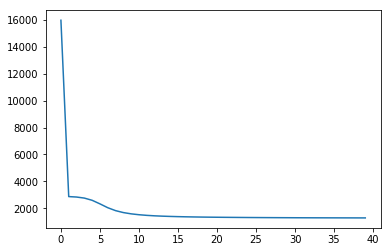

In [11]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

Выведем топы слов:

In [12]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    for word in model_artm.score_tracker["top_words"].last_topic_info[topic_name].tokens:
        print word,
    print

sbj0:  который человек право быть ребенок как также социальный свой это являться отношение себя государство они
sbj1:  что который свой быть ядро это этот его герой как они атом она человек такой
sbj2:  предложение слово который число например быть что как корень это или дробь речь пример такой
sbj3:  уравнение который этот что земля океан вода как быть территория являться это квадратный для вид
sbj4:  пушкин поэт что который стихотворение быть это свой год этот звук весь его лирика такой
sbj5:  быть при сила это тело этот что функция энергия для который если ток как такой
sbj6:  человек который свой что жизнь его герой быть это как произведение этот для литература русский
sbj7:  который человек общество развитие быть век политический это государство социальный как себя жизнь культура такой
sbj8:  страна государство население который быть этот территория год являться сша что хозяйство также время африка
sbj9:  быть который год государство война свой что становиться первый время как вес

Давайте посмотрим также на разреженность матриц:

In [ ]:
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [ ]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary_name="dictionary"))
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

In [ ]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15, num_document_passes=1)

Попробуем менять коэффициент регуляризации:

In [ ]:
model_artm.regularizers['SparsePhi'].tau = -5*1e4

In [ ]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15, num_document_passes=1)

In [ ]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    for word in model_artm.score_tracker["top_words"].last_topic_info[topic_name].tokens:
        print word,
    print

In [ ]:
# еще раз посмотрим на разреженность
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [ ]:
model_artm.save("my_model")

In [ ]:
model_artm.load("my_model")

Можно попросить матрицы в чистом виде:

In [ ]:
phi = model_artm.get_phi()

In [ ]:
phi

Матрица вероятностей тем в документах.

In [ ]:
theta = model_artm.get_theta()
theta

Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [ ]:
theta_test = model_artm.transform(batch_vectorizer, num_document_passes=10)